In [1]:
# For all wuhan muntants get RMSE from wuhan crystal structure.
# Get adj mat dist 
# plot one against the other. 
from prody import *
from biopandas.pdb import PandasPdb
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.stats.stats import pearsonr   

In [2]:
def distance_matrix_creator(PDB_filename):
    """"This function takes in a PDB it returns a symetrix MxM matrix that is rotation and shift independant"""""
    ppdb = PandasPdb()
    data = ppdb.read_pdb(PDB_filename)
    # make equal lengths..
    data.df['ATOM'] = data.df['ATOM'][(data.df['ATOM']['residue_number'].values >= 333) & (data.df['ATOM']['residue_number'].values <= 526)] 
    mut_removed = ppdb.df['ATOM']
    # print(len(mut_removed["residue_number"])-len(atom_data["residue_number"])) #different for alpha...? much smaller number of atoms?...
    # print(mut_removed["x_coord",])
    position_matrix = mut_removed[["residue_number","x_coord" , "y_coord" , "z_coord"]]
    # aggresgate and take mean of xyz values for each residue as an approximation.
    aggregation_functions = {'x_coord': 'mean', 'y_coord': 'mean', 'z_coord': 'mean'}
    position_matrix = position_matrix.groupby(position_matrix['residue_number']).aggregate(aggregation_functions)  
    # cartersian productcartersian product of distance. 
    dist_mat = distance_matrix(position_matrix,position_matrix,p=2) #p=2 for euclidian disntace
    return dist_mat 

def PDB_RMSD(PDB_aligned_file,mut_num):
    ''''Compare aligned alphafold to 6MOJ in root mean squared deviation distance between residues'''
    # open file 
    l_1 = PandasPdb().read_pdb('/mnt/ncshare/ozkilim/charge_pca_deepmut/PDB_samples/Wuhan_alfafold.pdb') # Wuhan 6MOJ 
    l_1.df['ATOM'] = l_1.df['ATOM'][(l_1.df['ATOM']['residue_number'].values != mut_num)] 

    l_2 = PandasPdb().read_pdb(PDB_aligned_file)
    l_2.df['ATOM'] = l_2.df['ATOM'][(l_2.df['ATOM']['residue_number'].values >= 333) & (l_2.df['ATOM']['residue_number'].values <= 526) & (l_2.df['ATOM']['residue_number'].values != mut_num)] 

    RMSD = PandasPdb.rmsd(l_1.df['ATOM'], l_2.df['ATOM'],
                    s='carbon') # all atoms, including hydrogens

    return RMSD

In [3]:
wuhan_dir = '/mnt/ncshare/ozkilim/charge_pca_deepmut/Wuhan_RBDs/structures/Wuhan_RBDs'
adj_mat_wuhan = distance_matrix_creator('/mnt/ncshare/ozkilim/charge_pca_deepmut/PDB_samples/Wuhan_alfafold.pdb')
output = []

variant_scores_path = "./SARS-CoV-2-RBD_DMS_variants/results/final_variant_scores/final_variant_scores.csv"

variants_names = {
    "Wuhan-Hu-1": "Wuhan-Hu-1",
    "N501Y": "Alpha", 
    "Beta": "Beta",
    "Delta": "Delta",
    "E484K": "Eta",
}

# Expression and Binding scores per variant background -- for the heatmap plots
scores_df = (
    pd.read_csv(variant_scores_path)
        .rename(columns = {"position":"site",
                           "delta_expr":"RBD expression", # rename for the selection menus 
                           "delta_bind":"ACE2 binding"    # rename for the selection menus 
                          })
        .replace({"target":variants_names})
)

wuhan = scores_df.loc[scores_df["target"] == "Wuhan-Hu-1"]

for file in os.listdir(wuhan_dir):
    try:
        folder_RBD = wuhan_dir+ '/' +file
        mut_name = file[-9:-4]
        mut_num = int(file[-8:-5])
        rmsd = PDB_RMSD(folder_RBD,mut_num)
        adj_mat = distance_matrix_creator(folder_RBD)
        adj_dist = np.abs(adj_mat_wuhan - adj_mat).mean() # get norm dist for example..
        
        RBD_expression = wuhan.loc[wuhan["mutation"]== mut_name]["RBD expression"].values
        print(RBD_expression[0])
        output.append([rmsd,adj_dist,RBD_expression[0]])
    except:
        pass
    
output = np.array(output)
# pickle the generated array
np.save("MSE_vs_adj_Mat_alphafoldversion.npy",output)

# remove mut in adjancenc mat?

-0.26435
-3.09786
-2.02712
0.1008
-0.2794
-1.9419099999999998
-1.4241
0.03273
-1.5546200000000001
-1.5714700000000001
-1.2857
-0.44398999999999994
-2.0333099999999997
0.17449
-1.01987
-1.69904
0.09444
-0.00075
-2.91681
-3.3003699999999996
-2.8873900000000003
-0.02804
-0.46715
-0.07733
0.20239000000000001
-2.78573
-0.35231999999999997
-0.07192
-0.56721
-0.38395
-0.6211399999999999
-0.75038
-0.10375
-1.09317
0.12140999999999999
-2.8022299999999998
0.05331
-0.856
0.052489999999999995
-2.36112
-0.85593
-3.58567
-2.38925
-0.0034200000000000003
-1.01247
-2.0655
-3.1284400000000003
-0.74737
-1.8003799999999999
-0.8461200000000001
-0.8082600000000001
-3.28879
-0.65733
-2.74465
-0.02256
-0.44976000000000005
-0.15930999999999998
-3.37189
-0.132
-0.63835
-1.4964
-2.99229
0.07094
-0.14886
-0.03833
nan
-0.28392
-1.00861
0.16161
-1.5967799999999999
0.10503
-1.5532299999999999
-0.40093
-0.86421
0.028810000000000002
-0.03167
0.02165
-2.5657099999999997
-1.8646900000000002
-0.09548
nan
-2.83452
-0.9152

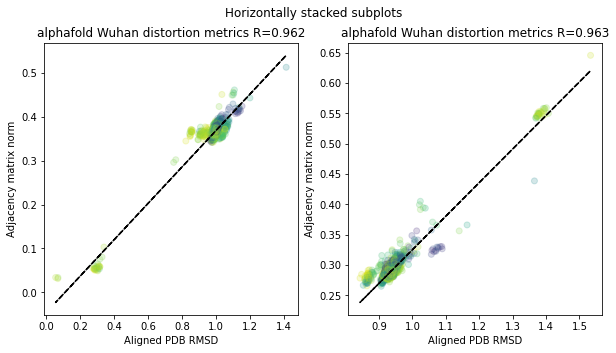

In [15]:
# Check how aligned structres RMSD vary with the adjacenc matrix norm to see if there is some bias in alignment...

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Horizontally stacked subplots')

output = np.load("MSE_vs_adj_Mat_alphafoldversion.npy")

ax1.set_title("alphafold Wuhan distortion metrics R={:.3f}".format((pearsonr(output[:,0],output[:,1])[0])))
ax1.scatter(output[:,0],output[:,1],c=output[:,2],alpha=0.2)
ax1.set_xlabel("Aligned PDB RMSD")
ax1.set_ylabel("Adjacency matrix norm")
m, b = np.polyfit(output[:,0], output[:,1], 1)
ax1.plot(output[:,0], m*output[:,0]+b, color='black',linestyle='dashed')


output = np.load("MSE_vs_adj_Mat.npy")
ax2.set_title("alphafold Wuhan distortion metrics R={:.3f}".format((pearsonr(output[:,0],output[:,1])[0])))
ax2.scatter(output[:,0],output[:,1],c=output[:,2],alpha=0.2)
ax2.set_xlabel("Aligned PDB RMSD")
ax2.set_ylabel("Adjacency matrix norm")
m, b = np.polyfit(output[:,0], output[:,1], 1)
ax2.plot(output[:,0], m*output[:,0]+b, color='black',linestyle='dashed')


one table with R reasults for all varients?... is more compressed?...  

#repete for each set?...

Corrolation between RMSE of each varient and mean distance of adjacency matrix. This is a validation of the alignemnt of the structures to show its usefull for downstream tasks. 







# cbar = ax1.colorbar()
# cbar.ax.set_ylabel('RBD expression', rotation=270)


# get R and P..
# color these by RBD expression?

# do same for other stuctures..? but not aligned..
# plot one against the other? some way of demonstrating ours in better? ... FOLDX reasults look into!



# produce full figures for paper. to show alignemnt of method is good...  can be small figures joined..
